# Baseball Changepoints

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from os import getenv
from tqdm import tqdm

from math import comb
from scipy.stats import chi2

In [2]:
def compute_binomial_LLR(hab, down=True, min_games=20):
    """
    Compute LLR comparing two hypotheses: the batting
    average/p is the same on the LHS/RHS and p is different
    on the LHS/RHS.

    We drop the combinatorics because they are common across
    the two hypotheses: e.g., the LHS has a factor of log(BAL C HL)
    and the RHS has a factor of log(BAR C HR)

    Relevant:
    - https://en.wikipedia.org/wiki/Wilks%27_theorem
    - https://en.wikipedia.org/wiki/Chi-squared_distribution
    
    """
    def _llr_no_combinatorics(hab):
        eps = 1E-6
        h, ab = hab.sum(axis=0)
        p = np.clip(h / ab, eps, 1 - eps)
        return h / ab, h * np.log(p) + (ab - h) * np.log(1-p)
    
    b0, logL = _llr_no_combinatorics(hab)

    # Compute the most likely changepoint using CUSUM
    cum_abs = np.cumsum(hab[:,1])
    cum_h = np.cumsum(hab[:,0])
    cumdiff = cum_h - b0 * cum_abs

    cumdiff_slice = cumdiff[min_games:-min_games]
    cp = cumdiff_slice.argmax() if down else cumdiff_slice.argmin()
    cp = min_games + cp
    
    bL, logLL = _llr_no_combinatorics(hab[:cp])
    bR, logLR = _llr_no_combinatorics(hab[cp:])
    
    LLR = 2 * (logLL + logLR - logL)
    p = 1 - chi2.cdf(LLR, 1) # probability of observing this LLR or higher
    # 1 ddof because LR model has 2 params, single model has 1
    
    return dict(
        bavg=b0,
        bavgL=bL,
        bavgR=bR,
        changepoint=cp,
        llr=LLR,
        pvalue=p
    )

In [3]:
data_dir = Path(getenv("HOME"), "data", "mlb-2023")

In [4]:
COLS = [
    "player_id", "player_name", "game_date", "abs", "hits"
]
df = pd.concat(
    [pd.read_csv(f)[COLS] for f in data_dir.glob("2023-*.csv")]
).reset_index(drop=True).rename(columns=dict(abs="atbats")).dropna()
df.game_date = pd.to_datetime(df.game_date)
df = df.sort_values("game_date").reset_index(drop=True)

In [5]:
players = df.groupby("player_id").atbats.sum().sort_values(ascending=False)
players = players[players > 100]
len(players)

449

In [6]:
sample_player_id = players.sample(n=1).index.values[0]
sample_player_id = 650859
player_df = df.query(f"player_id == {sample_player_id}")
sample_player_id, len(player_df)

(650859, 123)

In [7]:
bavg = player_df.hits.sum() / player_df.atbats.sum()
print(f"{bavg:.3f}")

0.265


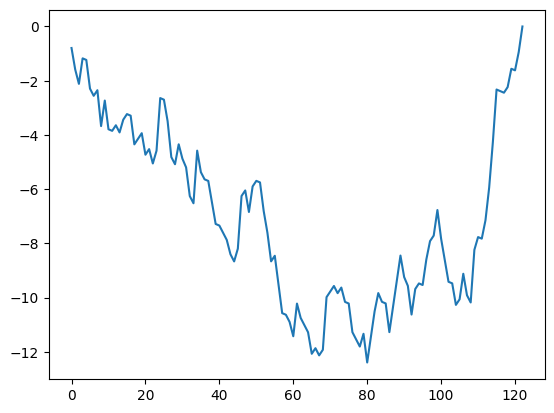

In [8]:
cusum = (player_df.hits - player_df.atbats * bavg).cumsum()
plt.plot(cusum.values)
plt.show()

In [9]:
htr = []
min_games, min_games_total = 15, 80
for _pid, player_df in tqdm(df.groupby("player_id")):
    if len(player_df) < min_games_total:
        continue
    player_df = player_df.sort_values("game_date", ascending=True).reset_index(drop=True)
    v = player_df[["hits", "atbats"]].astype("int").values
    htr.append(dict(
        player_name=player_df.player_name.iloc[0],
        id=_pid,
        ngames=len(player_df),
    ))
    htr[-1].update(compute_binomial_LLR(v, min_games=min_games))
    htr[-1]["change_date"] = player_df.game_date.iloc[htr[-1]["changepoint"]]
htr = pd.DataFrame(htr).sort_values("pvalue").reset_index(drop=True)
print(f"{len(htr)} tested hypotheses")

100%|█████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 1771.05it/s]

316 tested hypotheses


In [10]:
htr.head(10)

,player_name,id,ngames,bavg,bavgL,bavgR,changepoint,llr,pvalue,change_date
0,"Chapman, Matt",656305,140,0.239686,0.378641,0.204433,28,12.703081,0.000365,2023-05-02
1,"Murphy, Sean",669221,106,0.251351,0.304348,0.164286,65,9.473049,0.002085,2023-07-08
2,"Castro, Rodolfo",666801,83,0.211454,0.266667,0.103896,52,8.865068,0.002907,2023-06-14
3,"Mateo, Jorge",622761,105,0.216981,0.352941,0.180000,22,8.671920,0.003232,2023-04-30
4,"Jankowski, Travis",608671,90,0.263158,0.331034,0.166667,49,8.671014,0.003233,2023-07-19
5,"Rizzo, Anthony",519203,99,0.243968,0.303483,0.174419,52,8.532027,0.003490,2023-05-28
6,"Merrifield, Whit",593160,143,0.272395,0.302158,0.176923,109,8.357615,0.003841,2023-08-15
7,"De La Cruz, Elly",682829,97,0.234536,0.327869,0.191729,29,8.318531,0.003924,2023-07-09
8,"Arcia, Orlando",606115,138,0.264887,0.340782,0.220779,51,8.218366,0.004147,2023-06-20
9,"Slater, Austin",596103,83,0.270270,0.423077,0.210526,20,8.155787,0.004292,2023-06-21


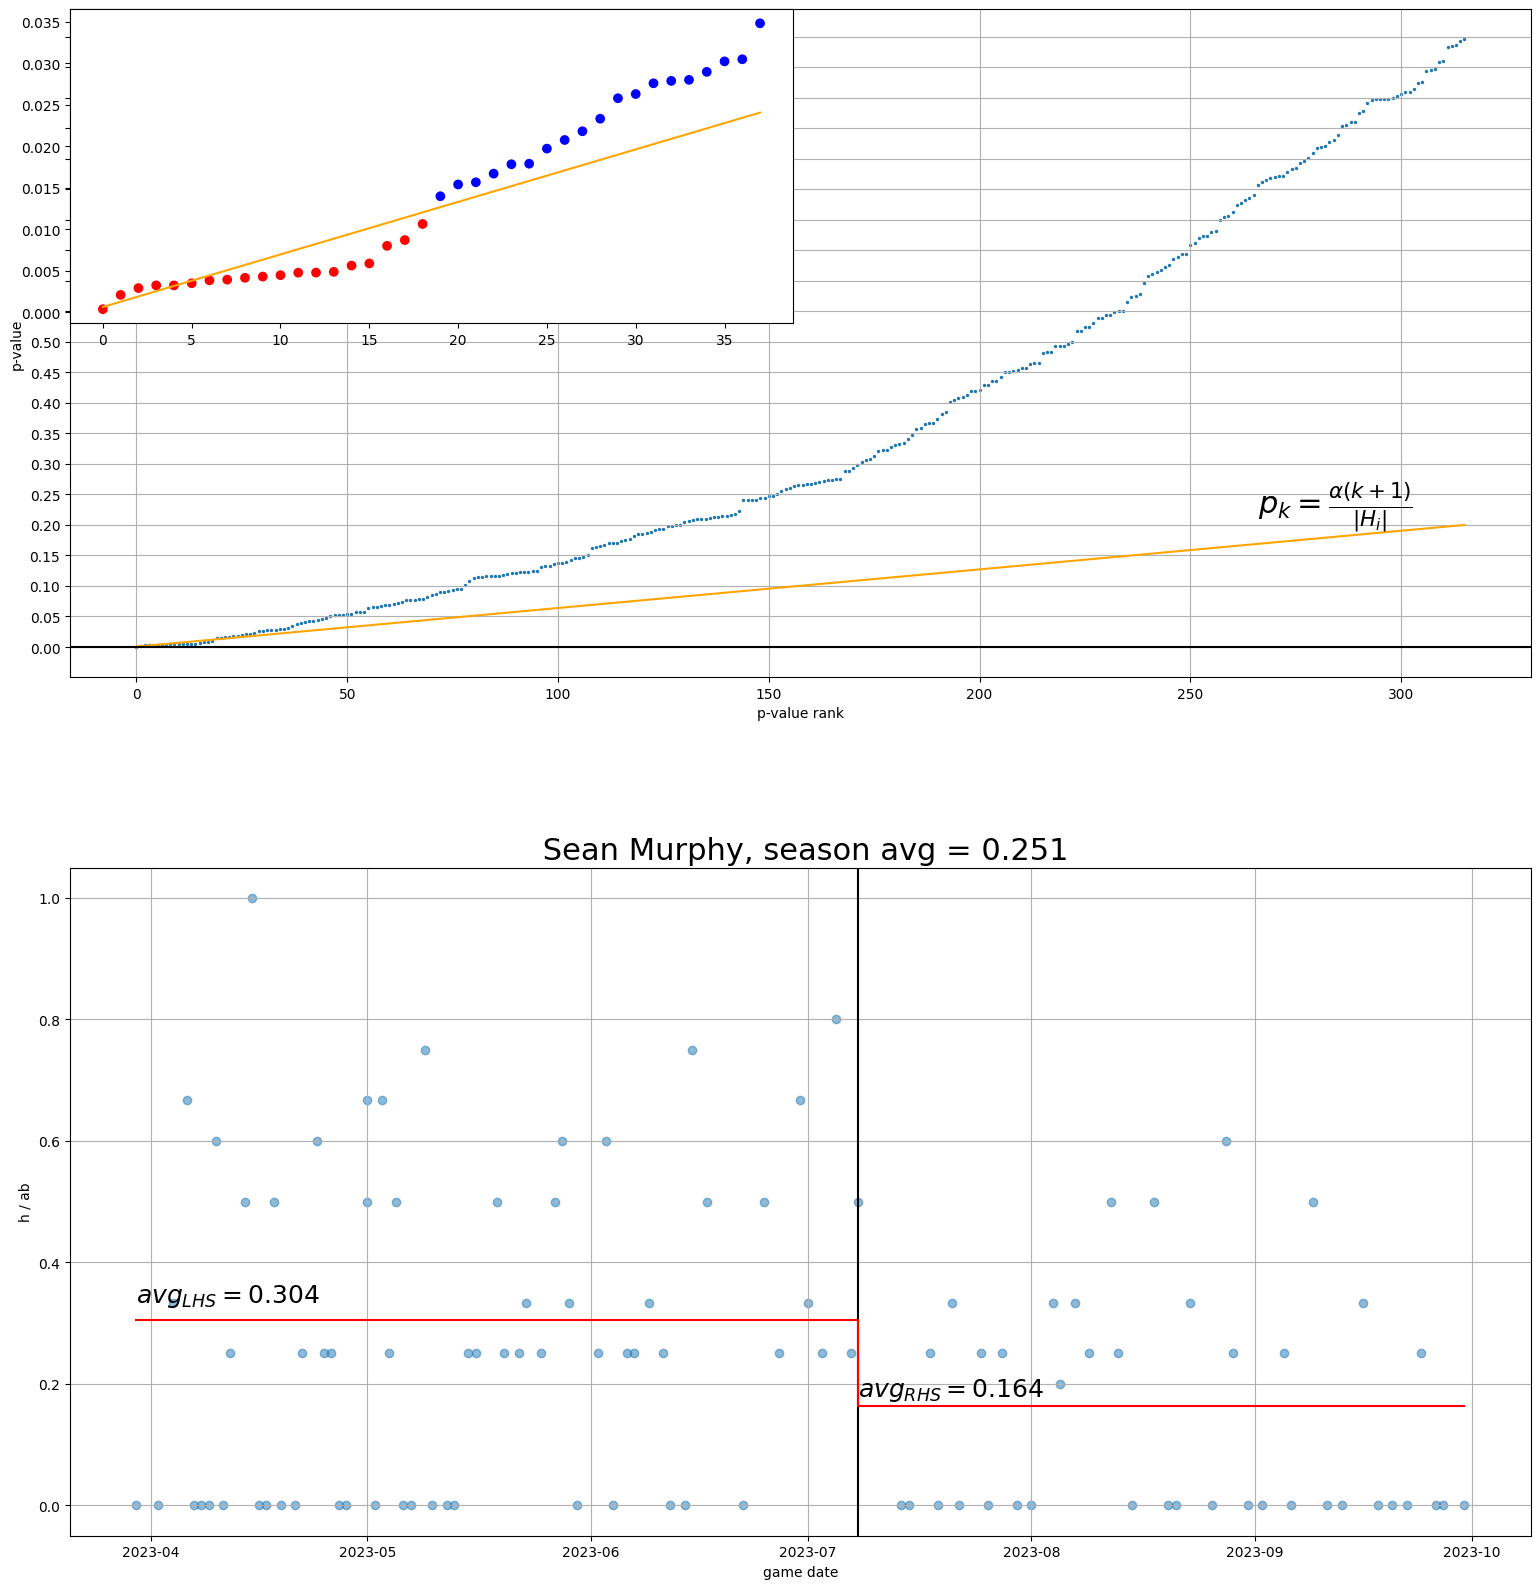

In [11]:
fdr = 0.20
prototype_id = 669221

fig = plt.figure(figsize=(16, 16))

ax = fig.add_subplot(2,1,1)
ps = htr.pvalue.values
kes = htr.index.values
thresholds = (1 + kes) * fdr / len(kes)
kmax = kes[ps < thresholds].max() + 1

ax.scatter(kes, ps, s=2)
ax.plot(kes, thresholds, color="orange")
ax.text(kes[-50], 1.1 * thresholds[-1], r"$p_k = \frac{\alpha (k + 1)}{|H_i|}$", fontsize=22)
ax.axhline(color="k")
ax.grid()

yti = np.arange(0., 1.01, 0.05)
ytl = [f"{_y:.2f}" if _y <= 0.5 else None for _y in yti]
ax.set_yticks(yti)
ax.set_yticklabels(ytl)
ax.set_xlabel("p-value rank")
ax.set_ylabel("p-value")

# Max index plus one to get the total number of discoveries
kmax = kes[ps <= thresholds].max() + 1

ax = fig.add_subplot(4, 2, 1)
colors = ["r"] * kmax + ["b"] * kmax
ax.scatter(kes[:2*kmax], ps[:2*kmax], c=colors)
ax.plot(kes[:2*kmax], thresholds[:2*kmax], color="orange")

ax = fig.add_subplot(2, 1, 2)
player_df = df.query(f"player_id == {prototype_id}")
ax.scatter(player_df.game_date, player_df.hits / player_df.atbats, alpha=0.5)
_dfline = htr.query(f"id == {prototype_id}").iloc[0]
ax.set_title(
    f"{' '.join(_dfline.player_name.split(',')[::-1])}, season avg = {_dfline.bavg:.3f}",
    fontsize=22,
)
ax.axvline(_dfline.change_date, color="k")

xpts = [player_df.game_date.min(), _dfline.change_date, player_df.game_date.max()]
ypts = [_dfline.bavgL, _dfline.bavgL, _dfline.bavgR]
ax.step(xpts, ypts, color="r")
ax.grid()
ax.set_xlabel("game date")
ax.set_ylabel("h / ab")
ax.text(xpts[0], 1.1 * ypts[0], rf"$avg_{{LHS}} = {ypts[0]:.3f}$", fontsize=18)
ax.text(xpts[1], 1.1 * ypts[2], rf"$avg_{{RHS}} = {ypts[2]:.3f}$", fontsize=18)

fig.tight_layout()
plt.show()

In [12]:
kmax

19